# Load and clean the data

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthBegin
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import timedelta
from datetime import datetime
import imageio
from tqdm import tqdm
from sklearn import preprocessing

In [2]:
# Read data file
df_all = pd.read_csv('ADNI-compact-dataset-2023-0601-orig.csv')

# Drop the cloumn with no info
df_all.drop(columns=['Unnamed: 12'], inplace=True)

# Convert 'EXAMDATE' to datetime format
df_all['EXAMDATE'] = pd.to_datetime(df_all['EXAMDATE'])

# Sort by 'RID' and 'EXAMDATE'
df_all = df_all.sort_values(['RID', 'EXAMDATE'])

# Replace the 'AGE' column in the original DataFrame with calculated age
df_bl = df_all[df_all['VISCODE'] == 'bl'][['RID', 'EXAMDATE', 'AGE']].rename(columns={'EXAMDATE': 'EXAMDATE_bl', 'AGE': 'AGE_bl'})
df_all = pd.merge(df_all, df_bl, on='RID', how='left')
df_all['AGE_DIFF'] = (df_all['EXAMDATE'] - df_all['EXAMDATE_bl']).dt.days / 365.25
df_all['AGE_NEW'] = df_all['AGE_bl'] + df_all['AGE_DIFF']
df_all['AGE'] = df_all['AGE_NEW'].round(1)
df_all = df_all.drop(columns=['EXAMDATE_bl', 'AGE_bl', 'AGE_DIFF', 'AGE_NEW'])

# Replace the text noted outliers and make sure ABETA values are numeric
df_all['ABETA'] = df_all['ABETA'].replace('<200', 100)
df_all['ABETA'] = df_all['ABETA'].replace('>1700', 2000)
df_all['ABETA'] = df_all['ABETA'].astype(float)

# Fill some missing values with NA - not applicable
df_all.fillna({'DX_bl': 'NA', 'PTMARRY': 'NA'}, inplace=True)

# Save the cleaned data as .csv file
df_all.to_csv('temp_cleaned.csv', index=False)

## Take a glance of the data

   RID VISCODE   EXAMDATE DX_bl   AGE PTGENDER  PTEDUCAT         PTETHCAT  \
0    2      bl 2005-09-08    CN  74.3     Male        16  Not Hisp/Latino   
1    2     m06 2006-03-06    CN  74.8     Male        16  Not Hisp/Latino   
2    2     m36 2008-08-27    CN  77.3     Male        16  Not Hisp/Latino   
3    2     m60 2010-09-22    CN  79.3     Male        16  Not Hisp/Latino   
4    2     m66 2011-03-04    CN  79.8     Male        16  Not Hisp/Latino   

  PTRACCAT  PTMARRY  ...      FDG  PET-CL  ABETA  TAU PTAU CDRSB  ADAS11  \
0    White  Married  ...  1.33615     NaN    NaN  NaN  NaN   0.0   10.67   
1    White  Married  ...  1.22282     NaN    NaN  NaN  NaN   0.0   10.67   
2    White  Married  ...      NaN     NaN    NaN  NaN  NaN   0.0   12.00   
3    White  Married  ...      NaN     NaN    NaN  NaN  NaN   0.0   14.00   
4    White  Married  ...      NaN     NaN    NaN  NaN  NaN   NaN     NaN   

   ADAS13  ADASQ4  MMSE  
0   18.67     5.0  28.0  
1   19.67     7.0  28.0  
2 

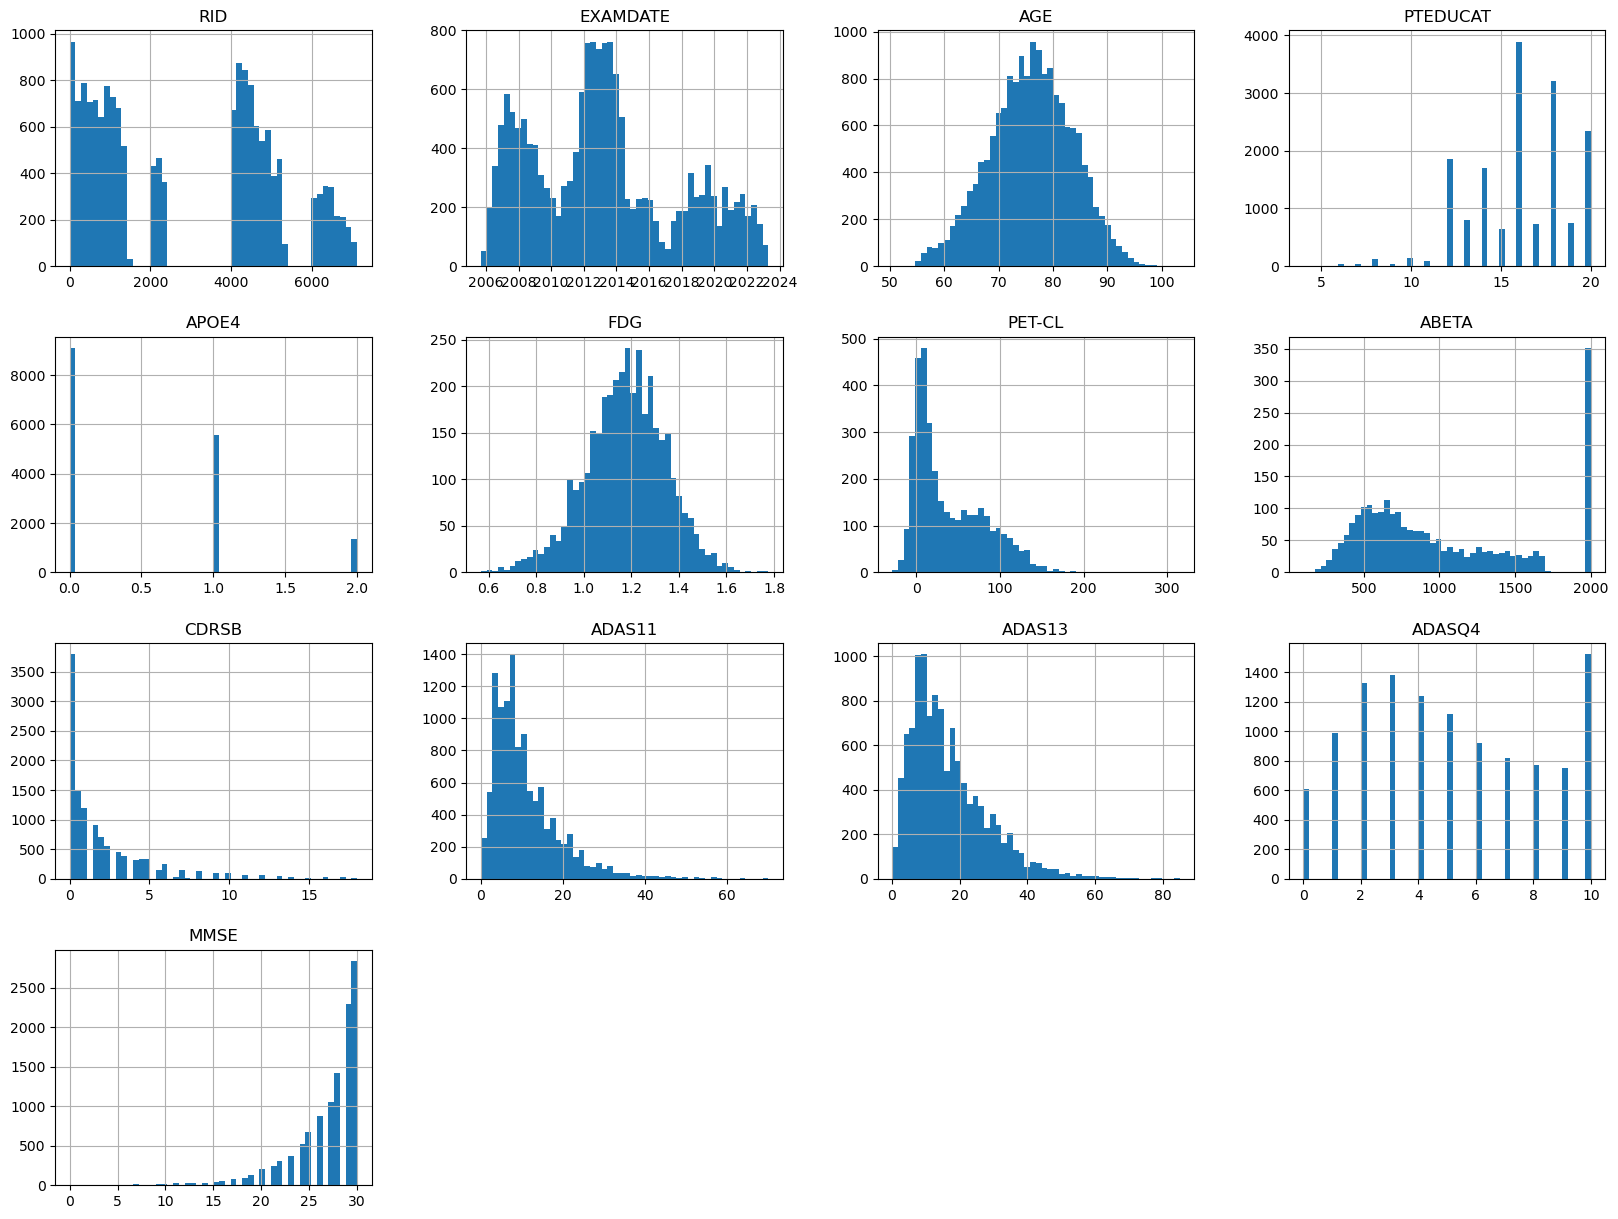

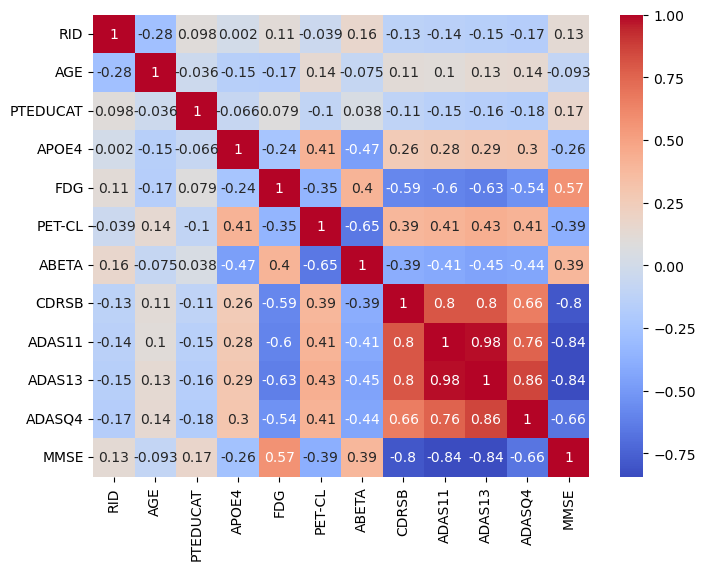

In [3]:
# Look at the first few rows of the DataFrame
print(df_all.head())

# Check the shape of the DataFrame (rows, columns)
print('\nShape of the DataFrame:\n', df_all.shape)

# Check the data types in the DataFrame
print('\nData types of each column:\n', df_all.dtypes)

# Check for missing or null values in the DataFrame
print('\nMissing or null values:\n', df_all.isnull().sum())

# Check basic statistical details like percentile, mean, std etc. of the DataFrame
print('\nBasic statistical details:\n', df_all.describe())

# Visualizing the distribution of numeric variables
df_all.hist(bins=50, figsize=(20,15))
plt.show()

# Plotting correlation matrix to understand the relationship between variables
plt.figure(figsize=(8,6))
sns.heatmap(df_all.corr(), annot=True, cmap='coolwarm')
plt.show()

In [4]:
print(f"There are in total {len(df_all['RID'].unique())} unique RIDs.")

is_dependent = df_all.groupby('RID')['DX_bl'].nunique().max() == 1
print('Each RID has only one DX_bl value:', is_dependent)

There are in total 2430 unique RIDs.
Each RID has only one DX_bl value: True


# Extract, merge, filter and interpolate data

In [5]:
# Take columns being used
df_PET = df_all[['RID', 'EXAMDATE','PET-CL']].dropna(subset=['PET-CL'])
df_ABETA = df_all[['RID', 'EXAMDATE', 'ABETA']].dropna(subset=['ABETA'])

df_DX = df_all[['RID', 'DX_bl']].drop_duplicates()

In [6]:
def merge_PET_ABETA(df_PET, df_ABETA, num_months):
    # Initialize empty df_merge
    df_merge = pd.DataFrame(columns=['RID', 'AVE_DATE', 'PET-CL', 'ABETA'])

    for i in df_PET.index:
        # Loop over each row in df_ABETA
        for j in df_ABETA.index:
            # Check if RID matches
            if (df_PET.loc[i, 'RID'] == df_ABETA.loc[j, 'RID']):
                # Check if dates are within num_months of each other
                if abs(df_PET.loc[i, 'EXAMDATE'] - df_ABETA.loc[j, 'EXAMDATE']) <= timedelta(days=num_months*30):
                    # Calculate average date
                    ave_date = df_PET.loc[i, 'EXAMDATE'] + (df_ABETA.loc[j, 'EXAMDATE'] - df_PET.loc[i, 'EXAMDATE']) / 2
                    # Append new row to df_merge
                    df_merge = pd.concat([df_merge, pd.DataFrame([{'RID': df_PET.loc[i, 'RID'], 
                                                            'AVE_DATE': ave_date, 
                                                            'PET-CL': df_PET.loc[i, 'PET-CL'], 
                                                            'ABETA': df_ABETA.loc[j, 'ABETA']}])], ignore_index=True)
    return df_merge


In [7]:
# merge_PET_ABETA(df_PET, df_ABETA, 12).to_csv('temp_merge_12m.csv', index=False)
# merge_PET_ABETA(df_PET, df_ABETA, 15).to_csv('temp_merge_15m.csv', index=False)
# merge_PET_ABETA(df_PET, df_ABETA, 18).to_csv('temp_merge_18m.csv', index=False)

df_merge_12m = pd.read_csv('temp_merge_12m.csv')
df_merge_15m = pd.read_csv('temp_merge_15m.csv')
df_merge_18m = pd.read_csv('temp_merge_18m.csv')

In [8]:
df_drop = df_all.dropna(subset=['PET-CL', 'ABETA'])

# print(len(df_PET), len(df_ABETA), len(df_drop), len(df_merge_12m), len(df_merge_15m), len(df_merge_18m))

print(f'There are {len(df_PET)} records of PET-CL in total.')
print(f'There are {len(df_ABETA)} records of ABETA in total.')
print(f'There are {len(df_drop)} records with both PET-CL and ABETA.')

print(f'There are {len(df_merge_12m)-len(df_drop)} more records when the allowed time limit is 12 months.')
print(f'There are {len(df_merge_15m)-len(df_drop)} more records when the allowed time limit is 15 months.')
print(f'There are {len(df_merge_18m)-len(df_drop)} more records when the allowed time limit is 18 months.')

There are 3594 records of PET-CL in total.
There are 2370 records of ABETA in total.
There are 1387 records with both PET-CL and ABETA.
There are 25 more records when the allowed time limit is 12 months.
There are 67 more records when the allowed time limit is 15 months.
There are 80 more records when the allowed time limit is 18 months.


In [9]:
df_merge = df_merge_18m

df_merge_duplicates = df_merge.groupby(['RID', 'AVE_DATE']).filter(lambda x: x['PET-CL'].nunique() > 1 or x['ABETA'].nunique() > 1)
df_merge = df_merge[~df_merge.index.isin(df_merge_duplicates.index)]

print(f'Delete {len(df_merge_duplicates)} inappropariate records (example as follows).')

Delete 4 inappropariate records (example as follows).


- Example for "inappropariate records"

| RID | AVE_DATE | PET-CL | ABETA |
|-----|----------|--------|-------|
| 227 | 11/12/2010 0:00 | 80.3163 | 323 |
| ~~227~~ | ~~7/25/2011 0:00~~ | ~~80.3163~~ | ~~314~~ |
| ~~227~~ | ~~7/25/2011 0:00~~ | ~~81.1764~~ | ~~323~~ |
| 227 | 4/5/2012 0:00 | 81.1764 | 314 |
| 2233 | 12/28/2010 0:00 | 15.0951 | 1195 |
| 2233 | 1/10/2013 0:00 | 34.731 | 1044 |
| ~~2233~~ | ~~8/7/2013 12:00~~ | ~~34.731~~ | ~~841.3~~ |
| ~~2233~~ | ~~8/7/2013 12:00~~ | ~~33.7245~~ | ~~1044~~ |
| 2233 | 3/5/2014 0:00 | 33.7245 | 841.3 |

In [10]:
filter_out_less_than = 3;
df_plot = df_merge.groupby('RID').filter(lambda x: len(x) >= filter_out_less_than)

# Sort by 'RID' and 'EXAMDATE'
df_plot['AVE_DATE'] = pd.to_datetime(df_plot['AVE_DATE'])
df_plot = df_plot.sort_values(['RID', 'AVE_DATE']).drop_duplicates()

print(f'There are {len(df_plot)} records after filtering out RIDs with number of records less than {filter_out_less_than}.')

There are 443 records after filtering out RIDs with number of records less than 3.


In [11]:
print(df_plot.dtypes)
df_plot.head()

RID                  int64
AVE_DATE    datetime64[ns]
PET-CL             float64
ABETA              float64
dtype: object


,RID,AVE_DATE,PET-CL,ABETA
0,31,2010-05-12 12:00:00,45.1437,1179.0
1,31,2010-12-01 00:00:00,45.1437,923.7
2,31,2013-04-02 12:00:00,58.6491,664.5
3,31,2016-01-26 00:00:00,69.3180,784.3
4,42,2010-09-29 12:00:00,9.4587,1011.0


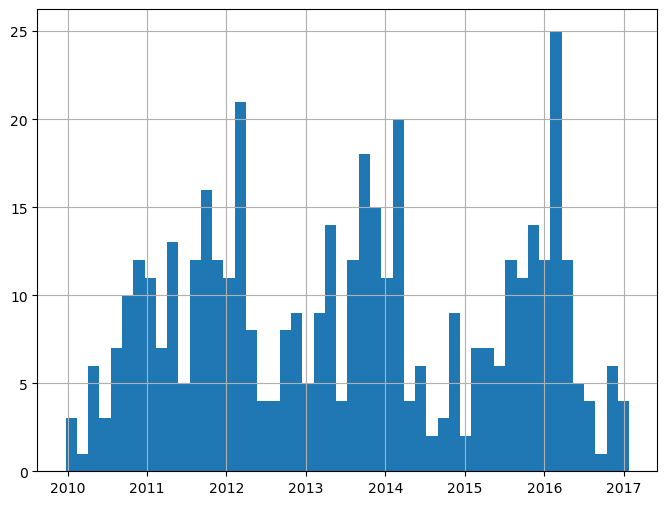

Earliest Record:  2009-12-23 12:00:00
Latest Record:  2017-01-25 12:00:00
There are 2590 days between the earlist record and latest record.
Minimum difference in dates across all RIDs is:  146 days 12:00:00


In [12]:
df_plot['AVE_DATE'].hist(bins=50, figsize=(8,6))
plt.show()

earliest_date = df_plot['AVE_DATE'].min()
latest_date = df_plot['AVE_DATE'].max()

print("Earliest Record: ", earliest_date)
print("Latest Record: ", latest_date)

# Calculate the total number of days between the two dates
total_days = (latest_date - earliest_date).days

# Number of frames
num_frames = 300

# Calculate the time difference between each frame
frame_time_difference = total_days / num_frames

print(f"There are {total_days} days between the earlist record and latest record.")
# print(f"The time difference between each frame should be approximately {frame_time_difference} days.")

# Calculate the difference between each date for each RID and get the minimum
min_diff_per_rid = df_plot.groupby('RID')['AVE_DATE'].diff().groupby(df_plot['RID']).min()

# Find the minimum difference across all RIDs
min_diff = min_diff_per_rid.min()

print('Minimum difference in dates across all RIDs is: ', min_diff)

In [13]:
# Copy df_plot to a new DataFrame
df_plot_copy = df_plot.copy()

# Set AVE_DATE as index on the copy
df_plot_copy.set_index('AVE_DATE', inplace=True)

# Create a list to hold the interpolated DataFrames
interpolated_list = []

# Iterate over each unique RID
for rid in df_plot_copy['RID'].unique():
    # Filter the DataFrame for the current RID
    df_rid = df_plot_copy[df_plot_copy['RID'] == rid].copy()
    
    # Resample to the start of each month and interpolate
    df_rid_monthly = df_rid.resample('MS').first()
    df_rid_interpolated = df_rid_monthly.interpolate(method='linear')

    # Append to the list of interpolated DataFrames
    interpolated_list.append(df_rid_interpolated)

# Concatenate all the DataFrames in the list
df_interpolated = pd.concat(interpolated_list)

# Reset the index
df_interpolated.reset_index(inplace=True)

# Ensure AVE_DATE is only year-month-day (no time info)
df_interpolated['AVE_DATE'] = df_interpolated['AVE_DATE'].dt.normalize()

In [14]:
print(df_interpolated.dtypes)
df_interpolated.head()

AVE_DATE    datetime64[ns]
RID                float64
PET-CL             float64
ABETA              float64
dtype: object


,AVE_DATE,RID,PET-CL,ABETA
0,2010-05-01,31.0,45.1437,1179.000000
1,2010-06-01,31.0,45.1437,1142.528571
2,2010-07-01,31.0,45.1437,1106.057143
3,2010-08-01,31.0,45.1437,1069.585714
4,2010-09-01,31.0,45.1437,1033.114286


In [15]:
# Ensure AVE_DATE is of datetime type
df_interpolated['AVE_DATE'] = pd.to_datetime(df_interpolated['AVE_DATE'])

# Create a new column NORM_DATE
df_interpolated['NORM_DATE'] = 0

# Iterate over each unique RID
for rid in df_interpolated['RID'].unique():
    # Filter the DataFrame for the current RID
    df_rid = df_interpolated[df_interpolated['RID'] == rid].copy()
    
    # Get the earliest date for the current RID
    min_date = df_rid['AVE_DATE'].min()
    
    # Subtract the earliest date from all dates and convert to months
    df_rid['NORM_DATE'] = (df_rid['AVE_DATE'] - min_date) / np.timedelta64(1, 'M')

    # Update the values in the original DataFrame
    df_interpolated.loc[df_rid.index, 'NORM_DATE'] = df_rid['NORM_DATE']

# Round NORM_DATE to the nearest whole number and convert to integer
df_interpolated['NORM_DATE'] = df_interpolated['NORM_DATE'].round().astype(int)


In [16]:
df_interpolated.head()

,AVE_DATE,RID,PET-CL,ABETA,NORM_DATE
0,2010-05-01,31.0,45.1437,1179.000000,0
1,2010-06-01,31.0,45.1437,1142.528571,1
2,2010-07-01,31.0,45.1437,1106.057143,2
3,2010-08-01,31.0,45.1437,1069.585714,3
4,2010-09-01,31.0,45.1437,1033.114286,4


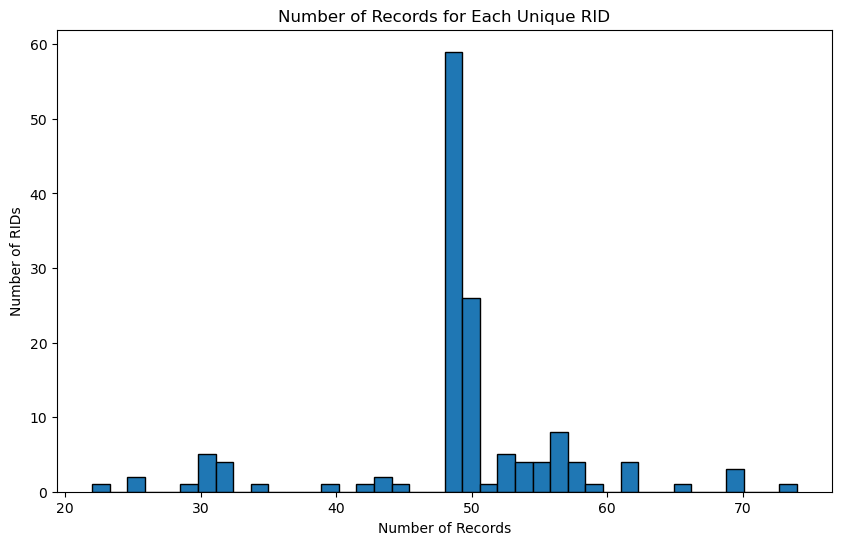

In [17]:
# Count the number of records for each unique RID
rid_counts = df_interpolated.groupby('RID').size().values.tolist()

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(rid_counts, bins=40, edgecolor='black')
plt.title('Number of Records for Each Unique RID')
plt.xlabel('Number of Records')
plt.ylabel('Number of RIDs')
plt.show()

# Plottings

In [18]:
def plot_grouped_data(df):
    # Create a figure and a set of subplots
    fig, ax = plt.subplots(figsize=(10,8))

    # Group data by 'RID'
    grouped = df.groupby('RID')

    # For each group, plot a line chart with 'PET-CL' as x and 'ABETA' as y
    for name, group in grouped:
        ax.plot(group['PET-CL'], group['ABETA'], marker='o', linestyle='-', ms=5)

    # Set labels
    ax.set_xlabel('PET-CL')
    ax.set_ylabel('ABETA')

    # Add a legend
    ax.legend()

    # Save the figure
    plt.savefig('figure.png')

    # Show the plot
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


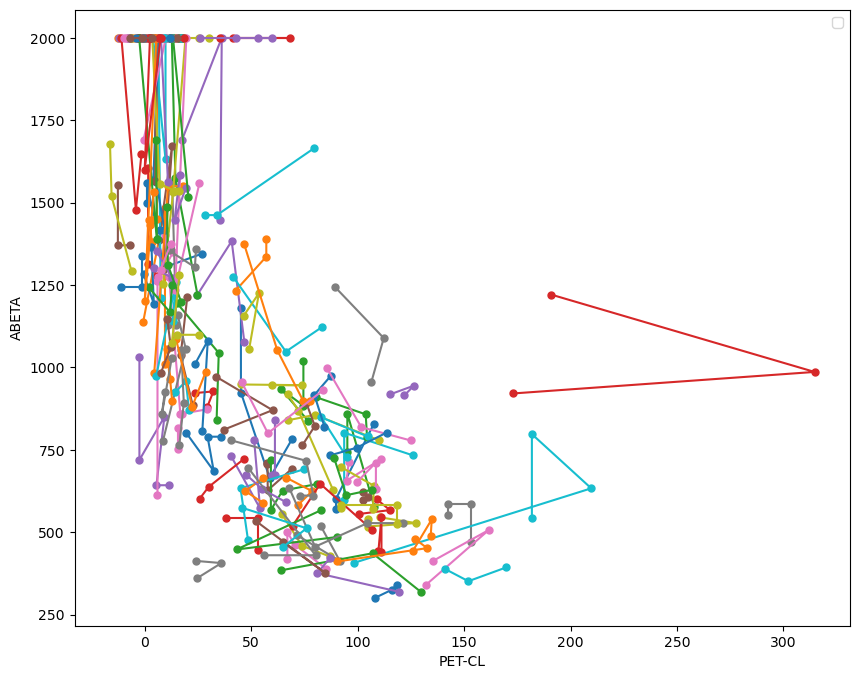

In [19]:
plot_grouped_data(df_plot)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


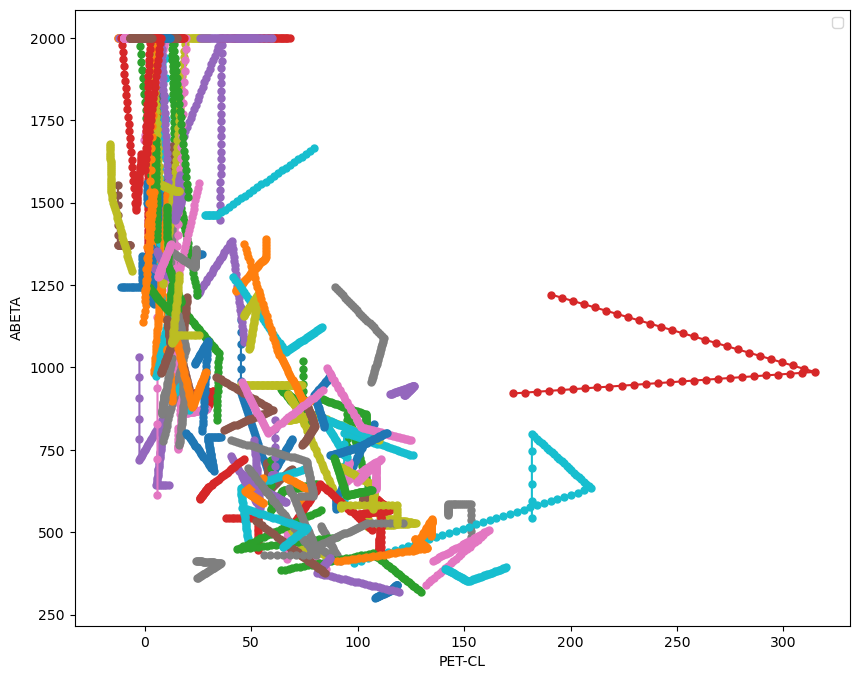

In [20]:
plot_grouped_data(df_interpolated)

In [21]:
# Get the minimum and maximum dates in the dataframe
min_date = df_interpolated['AVE_DATE'].min()
max_date = df_interpolated['AVE_DATE'].max()

# Get the range of dates from min to max
date_range = pd.date_range(start=min_date, end=max_date, freq='MS')

# Get a list of unique RIDs and assign a color to each one
unique_rids = df_interpolated['RID'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_rids)))
rid_color_map = dict(zip(unique_rids, colors))

# Prepare a list to hold the paths of the images for each frame
frames_paths = []

# Loop through each date in the range
for date in tqdm(date_range, desc='Creating frames'):
    # Filter the dataframe for records on or before the current date
    df_current = df_interpolated[df_interpolated['AVE_DATE'] <= date]

    # Create a scatter plot for the current date
    plt.figure(figsize=(10, 6))
    for rid, color in rid_color_map.items():
        df_rid = df_current[df_current['RID'] == rid]
        plt.scatter(df_rid['PET-CL'], df_rid['ABETA'], color=color, label=rid)
    plt.title(f'Date: {date.strftime("%Y-%m-%d")}')
    plt.xlabel('PET-CL')
    plt.ylabel('ABETA')
    
    # Set the range of the x-axis and y-axis
    plt.xlim([-30, 320])
    plt.ylim([150, 2100])

    # Save the plot as an image
    frame_path = f'frame_{date.strftime("%Y%m%d")}.png'
    plt.savefig(frame_path)
    plt.close()

    # Add the image path to the frames list
    frames_paths.append(frame_path)

# Create a GIF from the frames
images = [imageio.imread(frame_path) for frame_path in frames_paths]
imageio.mimsave('dynamic_plot.gif', images, duration=0.5)

# Remove the frame images
for frame_path in frames_paths:
    os.remove(frame_path)


Creating frames: 100%|██████████| 86/86 [03:03<00:00,  2.13s/it]
C:\Users\62520\AppData\Local\Temp\ipykernel_11700\1206282144.py:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(frame_path) for frame_path in frames_paths]


In [22]:
# Get the maximum NORM_DATE in the dataframe
max_norm_date = df_interpolated['NORM_DATE'].max()

# Get a list of unique RIDs and assign a color to each one
unique_rids = df_interpolated['RID'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_rids)))
rid_color_map = dict(zip(unique_rids, colors))

# Prepare a list to hold the paths of the images for each frame
frames_paths = []

# Loop through each date in the range
for norm_date in tqdm(range(max_norm_date + 1), desc='Creating frames'):
    # Filter the dataframe for records on or before the current norm_date
    df_current = df_interpolated[df_interpolated['NORM_DATE'] <= norm_date]

    # Create a scatter plot for the current date
    plt.figure(figsize=(10, 6))
    for rid, color in rid_color_map.items():
        df_rid = df_current[df_current['RID'] == rid]
        plt.scatter(df_rid['PET-CL'], df_rid['ABETA'], color=color, label=rid)
    plt.title(f'Month: {norm_date}')
    plt.xlabel('PET-CL')
    plt.ylabel('ABETA')

    # Set the range of the x-axis and y-axis
    plt.xlim([-30, 320])
    plt.ylim([150, 2100])

    # Save the plot as an image
    frame_path = f'frame_{norm_date}.png'
    plt.savefig(frame_path)
    plt.close()

    # Add the image path to the frames list
    frames_paths.append(frame_path)

# Create a GIF from the frames
images = [imageio.imread(frame_path) for frame_path in frames_paths]
imageio.mimsave('dynamic_plot_norm.gif', images, duration=0.5)

# Remove the frame images
for frame_path in frames_paths:
    os.remove(frame_path)


Creating frames: 100%|██████████| 74/74 [02:23<00:00,  1.94s/it]
C:\Users\62520\AppData\Local\Temp\ipykernel_11700\2996282819.py:39: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(frame_path) for frame_path in frames_paths]


<img src="dynamic_plot.gif" width="750" align="center">

<img src="dynamic_plot_norm.gif" width="750" align="center">

In [23]:
# Create an empty figure
fig = go.Figure()

# Group data by 'RID'
grouped = df_plot.groupby('RID')

# For each group, add a scatter plot to the figure
for name, group in grouped:
    fig.add_trace(go.Scatter(
        x=group['PET-CL'],
        y=group['ABETA'],
        mode='markers+lines',
        name=str(name),
        text=group['AVE_DATE'].astype(str),
        hovertemplate=
        '<b>EXAMDATE</b>: %{text}' +
        '<br><b>PET-CL</b>: %{x}' +
        '<br><b>ABETA</b>: %{y}' 
    ))

# Set labels
fig.update_layout(
    xaxis_title='PET-CL',
    yaxis_title='ABETA',
    title='Scatter plot of ABETA against PET-CL',
    hovermode="closest",
    autosize=False,
    width=1000,
    height=700,
)

# Show the plot
fig.show()

In [24]:
# Group data by 'RID'
grouped = df_plot.groupby('RID')

# Initialize min-max scaler
min_max_scaler = preprocessing.MinMaxScaler()

# Convert 'AVE_DATE' to numerical and scale to [0,1]
df_plot['AVE_DATE_NUM'] = min_max_scaler.fit_transform(df_plot['AVE_DATE'].values.reshape(-1,1))

# For each group, add a scatter plot to the figure
for name, group in grouped:
    fig.add_trace(go.Scatter(
        x=group['PET-CL'],
        y=group['ABETA'],
        mode='markers+lines',
        name=str(name),
        marker=dict(
            color=group['AVE_DATE_NUM'], # set color to an array/list of desired values
            colorscale='Bluered', # choose a colorscale
            colorbar=dict(
                title="Date",
                tickvals=[0,1],
                ticktext=["Oldest","Most Recent"]
            ),
            line=dict(
                color=group['AVE_DATE_NUM'], 
                colorscale='Bluered', 
                width=2,
                cmin=group['AVE_DATE_NUM'].min(),
                cmax=group['AVE_DATE_NUM'].max()
            )
        ),
        text=group['AVE_DATE'].astype(str),
        hovertemplate=
        '<b>EXAMDATE</b>: %{text}' +
        '<br><b>PET-CL</b>: %{x}' +
        '<br><b>ABETA</b>: %{y}' 
    ))

# Set labels
fig.update_layout(
    xaxis_title='PET-CL',
    yaxis_title='ABETA',
    title='Scatter plot of ABETA against PET-CL',
    hovermode="closest",
    autosize=False,
    width=1000,
    height=700,
)

# Show the plot
fig.show()


In [25]:
def map_val_to_color(val, colorscale):
    # Map a value between 0 and 1 to a color in the colorscale
    scaled_val = val * (len(colorscale) - 1)
    i = int(scaled_val)
    frac = scaled_val - i
    if i+1 < len(colorscale):
        color = [int((1 - frac) * colorscale[i][j] + frac * colorscale[i + 1][j]) for j in range(3)]
    else:
        color = colorscale[i]
    return 'rgb(' + str(color[0]) + ',' + str(color[1]) + ',' + str(color[2]) + ')'


# A colorscale from black (0,0,0) to yellow (255,255,0)
colorscale = [[0,0,0], [255,255,0]]

# For each group, add a scatter plot to the figure
for name, group in grouped:
    # Create scatter plot for markers
    fig.add_trace(go.Scatter(
        x=group['PET-CL'],
        y=group['ABETA'],
        mode='markers',
        name=str(name),
        marker=dict(
            color=group['AVE_DATE_NUM'], # set color to an array/list of desired values
            colorscale='Bluered', # choose a colorscale
            colorbar=dict(
                title="Date",
                tickvals=[0,1],
                ticktext=["Oldest","Most Recent"]
            ),
        ),
        text=group['AVE_DATE'].astype(str),
        hovertemplate=
        '<b>EXAMDATE</b>: %{text}' +
        '<br><b>PET-CL</b>: %{x}' +
        '<br><b>ABETA</b>: %{y}' 
    ))
    
    # Create line plot for each pair of points
    for i in range(1, len(group)):
        line_color = map_val_to_color(group['AVE_DATE_NUM'].iloc[i], colorscale)
        fig.add_trace(go.Scatter(
            x=[group['PET-CL'].iloc[i-1], group['PET-CL'].iloc[i]],
            y=[group['ABETA'].iloc[i-1], group['ABETA'].iloc[i]],
            mode='lines',
            line=dict(
                color=line_color,
                width=2
            ),
            showlegend=False
        ))

# Set labels
fig.update_layout(
    xaxis_title='PET-CL',
    yaxis_title='ABETA',
    title='Scatter plot of ABETA against PET-CL',
    hovermode="closest",
    autosize=False,
    width=1000,
    height=700,
)

# Show the plot
fig.show()
